In [ ]:
!pip install kaggle -Uqq
!mkdir /root/.kaggle
!mkdir model_checkpoints
!cp /content/drive/MyDrive/kaggle.json  /root/.kaggle

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory


In [ ]:
!pip install wandb -Uqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00


In [ ]:
!kaggle datasets download -d preetviradiya/brian-tumor-dataset
!mkdir data
!unzip -d data -q /content/brian-tumor-dataset.zip
!rm -rf /content/brian-tumor-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset
License(s): GPL-2.0
 99% 106M/107M [00:05<00:00, 23.6MB/s]
100% 107M/107M [00:05<00:00, 21.2MB/s]


In [ ]:
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

from tensorflow.keras import layers

import warnings

warnings.filterwarnings("ignore")

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import wandb
from wandb.keras import WandbCallback
from pathlib import Path

In [ ]:
from dataclasses import dataclass


@dataclass
class Parameters:
    learning_rate: float = 0.001
    batch_size: int = 32
    data_dir = Path('/content/data/Brain Tumor Data Set/')
    train_dir = data_dir / 'Brain Tumor Data Set'
    verbose = 1
    epochs = 100
    img_size = 224
    img_shape = (img_size, img_size, 3)
    class_names = None
    seed = 42

config = Parameters()

In [ ]:
train_loader, val_loader = tf.keras.utils.image_dataset_from_directory(
  config.train_dir,
  validation_split=0.2,
  subset="both",
  seed=42,
  image_size=(config.img_size, config.img_size),
  batch_size=config.batch_size)

Found 4514 files belonging to 2 classes.
Using 3612 files for training.
Using 902 files for validation.


In [ ]:
config.class_names = train_loader.class_names
config.num_classes = len(config.class_names)
print(config.class_names)

['Brain Tumor', 'Healthy']


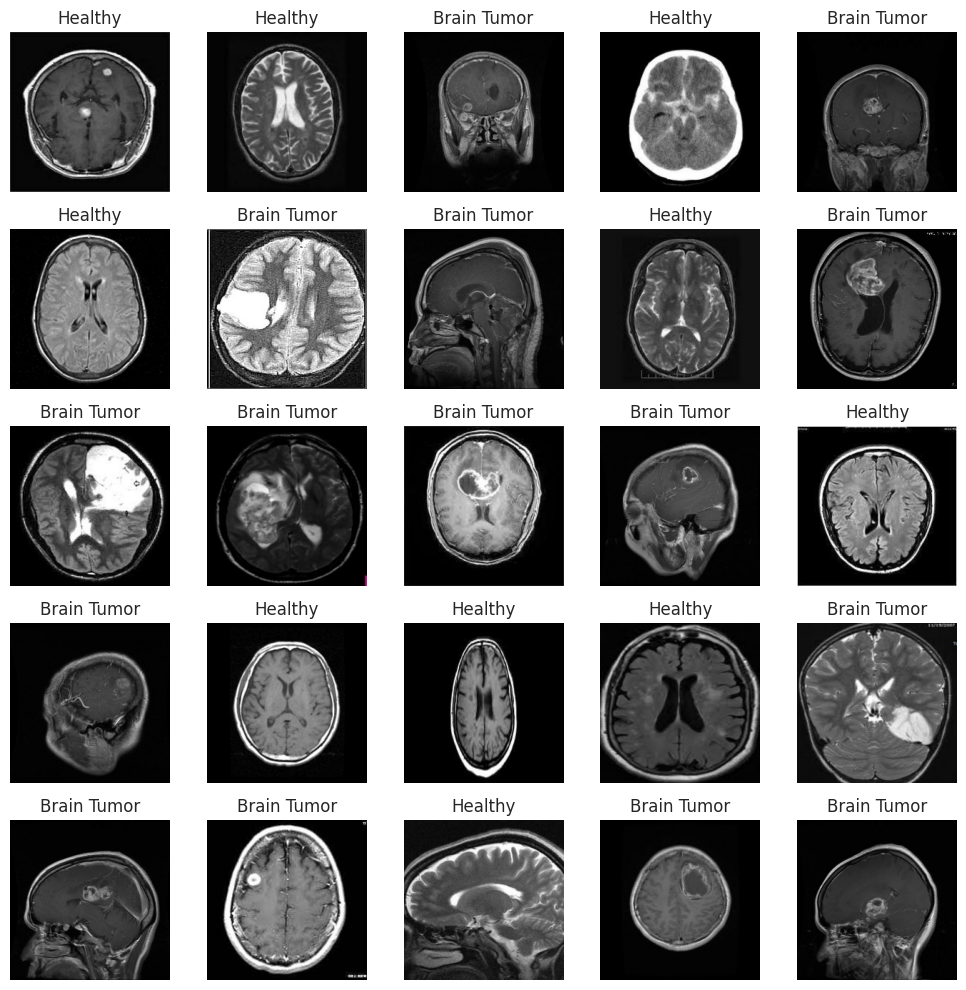

In [ ]:
def plot_images(dataset, class_names, num_images=25):
    # Get a batch of images and labels from the dataset
    image_batch, label_batch = next(iter(dataset))

    plt.figure(figsize=(10, 10))
    sns.set_style("whitegrid")
    for i in range(num_images):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        label = class_names[label_batch[i]]
        plt.title(label)
        plt.axis("off")
    plt.tight_layout()

plot_images(train_loader, class_names=train_loader.class_names)

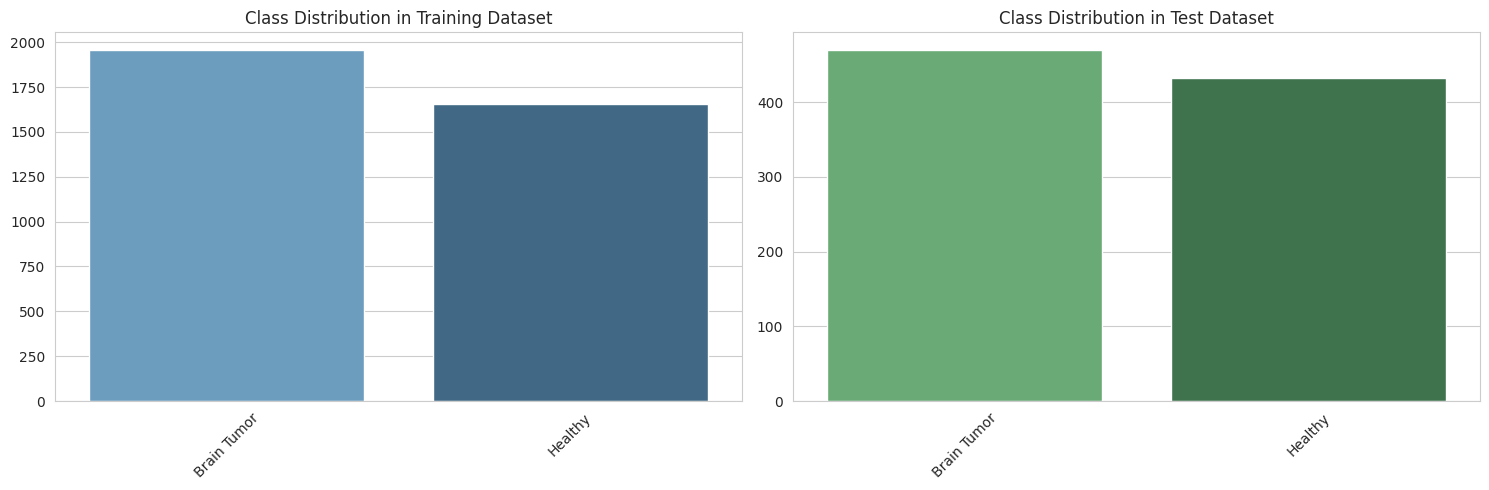

In [ ]:
def plot_class_distribution(train_ds, test_ds, class_names):
    # Get the class distributions in the datasets
    train_class_distribution = Counter([class_names[label] for images, labels in train_ds for label in labels])
    test_class_distribution = Counter([class_names[label] for images, labels in test_ds for label in labels])

    # Sort the keys and values of the class distributions
    train_keys, train_values = zip(*sorted(train_class_distribution.items()))
    test_keys, test_values = zip(*sorted(test_class_distribution.items()))

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot the class distribution in the training dataset
    sns.barplot(x=list(train_keys), y=list(train_values), ax=axs[0], palette="Blues_d")
    axs[0].set_title('Class Distribution in Training Dataset')
    axs[0].tick_params(axis='x', rotation=45)

    # Plot the class distribution in the test dataset
    sns.barplot(x=list(test_keys), y=list(test_values), ax=axs[1], palette="Greens_d")
    axs[1].set_title('Class Distribution in Test Dataset')
    axs[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

plot_class_distribution(train_loader, val_loader, config.class_names)

In [ ]:
rescaling = layers.Rescaling(1.0 / 255)
resize = layers.Resizing(config.img_size, config.img_size)
augmentation_layer = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", seed=42),
    layers.RandomRotation(0.3, seed=42),
    layers.RandomZoom(0.3, seed=42),
    # layers.RandomTranslation(0.3, 0.3, seed=42),
    ])

In [ ]:
def create_model():
    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential()

    # Add a 2D convolution layer with 32 filters, a 5x5 kernel, and 'relu' activation function
    model.add(layers.Conv2D(32, (5, 5), activation='relu', padding="same"))

    # Add a max pooling layer
    model.add(layers.MaxPooling2D((2, 2)))

    # Add another convolution and max pooling layer with different settings
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(layers.MaxPooling2D((2, 2)))

    # Add a third convolution and max pooling layer with different settings
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(layers.MaxPooling2D((2, 2)))
     # Flatten the tensor output from the previous layer to create a single long feature vector
    model.add(layers.Flatten())

    # Add a dense layer with 128 neurons and 'relu' activation function
    model.add(layers.Dense(128, activation='relu'))

    # Add batch normalization layer to normalize the activations of the previous layer
    model.add(layers.BatchNormalization())

    # Add a dropout layer to prevent overfitting
    model.add(layers.Dropout(0.5))

    # Add the output layer with a single neuron (for binary classification) and 'sigmoid' activation function
    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model

In [ ]:
model = create_model()
batch = next(iter(train_loader))
outputs = model(batch[0])
model.summary(expand_nested=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (32, 224, 224, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2  (32, 112, 112, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 112, 112, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 56, 56, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 56, 56, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (32, 28, 28, 128)         0

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()
roc_auc = tf.keras.metrics.AUC(curve='ROC', name='roc_auc')
accuracy = tf.keras.metrics.BinaryAccuracy(name='accuracy')

In [ ]:
# define callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
checkpoint_filepath = "/content/model_checkpoints/models_resnet_50/model_{epoch:02d}_val_roc_auc_{val_roc_auc:.4f}_val_loss_{val_loss:.4f}_val_accuracy_{val_accuracy:.4f}.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    save_freq="epoch",
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
train_ds = train_loader.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_loader.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=[roc_auc, accuracy])

In [ ]:
# If you don't have these installed
!pip install pydot
!apt-get install graphviz -y
from tensorflow.keras.utils import plot_model

# Create a diagram of the model architecture

plot_model(model, to_file='HALNet_2_Model.png', show_shapes=True, show_layer_names=True)
from google.colab import files
files.download('HALNet_2_Model.png')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import userdata

In [ ]:
# from google.colab import userdata
WANDB_API_KEY = userdata.get('wandb_api')

In [ ]:
wandb.login(key=WANDB_API_KEY)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
run = wandb.init(project="cortex", entity="shivanikotian18", job_type="train", group='baseline',tags=['baseline'], config=config)
assert run is wandb.run, "Something went wrong"
#train and validate the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config.epochs,
    callbacks=[checkpoint, WandbCallback(save_weights_only=False),reduce_lr, early_stopping],
)
run.finish()

Epoch 1/100
  6/113 [>.............................] - ETA: 7s - loss: 0.9625 - roc_auc: 0.5079 - accuracy: 0.5417

113/113 [==============================] - ETA: 0s - loss: 0.5604 - roc_auc: 0.7873 - accuracy: 0.7267

wandb: Adding directory to artifact (/content/wandb/run-20240502_234112-ua2dsf8d/files/model-best)... Done. 0.8s


113/113 [==============================] - 23s 143ms/step - loss: 0.5604 - roc_auc: 0.7873 - accuracy: 0.7267 - val_loss: 2.4462 - val_roc_auc: 0.7345 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 0.3680 - roc_auc: 0.9160 - accuracy: 0.8369

wandb: Adding directory to artifact (/content/wandb/run-20240502_234112-ua2dsf8d/files/model-best)... Done. 1.4s


113/113 [==============================] - 14s 120ms/step - loss: 0.3680 - roc_auc: 0.9160 - accuracy: 0.8369 - val_loss: 0.3239 - val_roc_auc: 0.9499 - val_accuracy: 0.8736 - lr: 0.0010
Epoch 3/100
113/113 [==============================] - 7s 61ms/step - loss: 0.2511 - roc_auc: 0.9639 - accuracy: 0.9048 - val_loss: 0.3486 - val_roc_auc: 0.9683 - val_accuracy: 0.8470 - lr: 0.0010
Epoch 4/100
112/113 [============================>.] - ETA: 0s - loss: 0.1635 - roc_auc: 0.9850 - accuracy: 0.9428

wandb: Adding directory to artifact (/content/wandb/run-20240502_234112-ua2dsf8d/files/model-best)... Done. 5.2s


113/113 [==============================] - 18s 159ms/step - loss: 0.1627 - roc_auc: 0.9852 - accuracy: 0.9432 - val_loss: 0.2027 - val_roc_auc: 0.9884 - val_accuracy: 0.9279 - lr: 0.0010
Epoch 5/100
112/113 [============================>.] - ETA: 0s - loss: 0.1009 - roc_auc: 0.9947 - accuracy: 0.9721

wandb: Adding directory to artifact (/content/wandb/run-20240502_234112-ua2dsf8d/files/model-best)... Done. 0.7s


113/113 [==============================] - 10s 89ms/step - loss: 0.1004 - roc_auc: 0.9948 - accuracy: 0.9723 - val_loss: 0.1096 - val_roc_auc: 0.9951 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 6/100
112/113 [============================>.] - ETA: 0s - loss: 0.0601 - roc_auc: 0.9981 - accuracy: 0.9852

wandb: Adding directory to artifact (/content/wandb/run-20240502_234112-ua2dsf8d/files/model-best)... Done. 0.9s


113/113 [==============================] - 12s 107ms/step - loss: 0.0599 - roc_auc: 0.9981 - accuracy: 0.9853 - val_loss: 0.0956 - val_roc_auc: 0.9929 - val_accuracy: 0.9778 - lr: 0.0010
Epoch 7/100
112/113 [============================>.] - ETA: 0s - loss: 0.0350 - roc_auc: 0.9996 - accuracy: 0.9925

wandb: Adding directory to artifact (/content/wandb/run-20240502_234112-ua2dsf8d/files/model-best)... Done. 0.9s


113/113 [==============================] - 12s 110ms/step - loss: 0.0349 - roc_auc: 0.9996 - accuracy: 0.9925 - val_loss: 0.0648 - val_roc_auc: 0.9942 - val_accuracy: 0.9856 - lr: 0.0010
Epoch 8/100
113/113 [==============================] - 7s 60ms/step - loss: 0.1036 - roc_auc: 0.9931 - accuracy: 0.9610 - val_loss: 0.1766 - val_roc_auc: 0.9851 - val_accuracy: 0.9446 - lr: 0.0010
Epoch 9/100
113/113 [==============================] - 7s 59ms/step - loss: 0.0720 - roc_auc: 0.9971 - accuracy: 0.9792 - val_loss: 0.0729 - val_roc_auc: 0.9930 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 10/100
112/113 [============================>.] - ETA: 0s - loss: 0.0265 - roc_auc: 0.9991 - accuracy: 0.9955
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
113/113 [==============================] - 7s 60ms/step - loss: 0.0264 - roc_auc: 0.9991 - accuracy: 0.9956 - val_loss: 0.0814 - val_roc_auc: 0.9919 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 11/100
113/113 [==================

accuracy,▁▄▆▇▇██▇▇████████
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▆▄▃▂▂▁▂▂▁▁▁▁▁▁▁▁
roc_auc,▁▅▇██████████████
val_accuracy,▁▆▆▇███▇█████████
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_roc_auc,▁▇▇██████████████
accuracy,0.99889
best_epoch,6
best_val_loss,0.06475
epoch,16
